# 1. Fisrt order proximity with negative sampling

In [5]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from matplotlib import pyplot as plt 
np.random.seed(15)


#Load data
adjlist = nx.read_adjlist("karate_club.adjlist", nodetype=int)
karate_label = np.loadtxt("karate_label.txt")
Graph = nx.read_adjlist("karate_club.adjlist", nodetype=int)
node_number = nx.to_pandas_adjacency(Graph).columns


adj = nx.to_numpy_array(adjlist)
label = karate_label[:,-1]

print(adj.shape)
print(label.shape)


(34, 34)
(34,)


In [6]:
def first_prox(node_vec1,node_vec2):
    mul = np.dot(node_vec1.T,node_vec2)
    return 1/(1+np.exp(-mul))

In [7]:
OH = np.identity(len(adj[0]))
OH.shape

(34, 34)

In [8]:
def first_order(epoch, lr,n_num):
    low_dim = np.random.rand(OH.shape[0],2)
    vec = np.matmul(OH,low_dim) #shape (34,2)
    
    for _ in range(epoch):
        loss = []
        for node in range(vec.shape[0]):
            #find near or not
            near_index = np.nonzero(adj[node])[0]
            tem = [ii for ii in range(34)]
            non_near_index = list(set(tem) - set(near_index))
            #for negative
            sample_not_near_index = np.random.choice(non_near_index,n_num,replace=False)
            #node_vec
            node_vec = vec[node]
            
            for pos in near_index:
                pos_vec = vec[pos]
                neg_vecs = vec[sample_not_near_index]
                #updates
                vec[node] -= lr*(first_prox(node_vec,pos_vec)-1)*pos_vec
                
                for neg in neg_vecs:
                    vec[node] -= lr*(first_prox(node_vec,neg))*neg
                
                

                
                loss.append(first_prox(node_vec,pos_vec)-1)
        loss_epoch.append(-np.mean(loss))
    return vec

In [9]:
loss_epoch = []
low_vec = first_order(100,0.01,5)

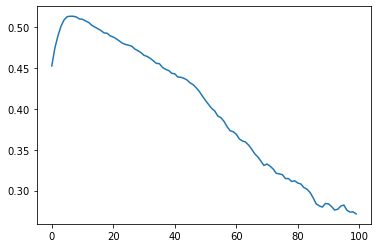

In [10]:
plt.plot(loss_epoch)

# T-SNE (first-order proximity)

- the membership number are located nearly when they Wij value is "one"

In [11]:
ans = np.dot(adj,low_vec)

In [12]:
node_number
label
label_fix = []
for i in node_number:
    tem = label[i]
    label_fix.append(tem)

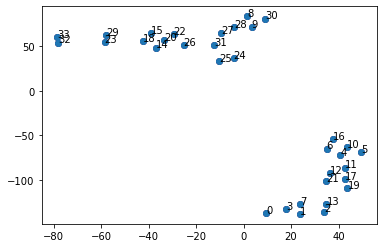

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(learning_rate=100,perplexity=6)
transformed = model.fit_transform(ans)
xs = transformed[:,0]
ys = transformed[:,1]

for i in range(len(xs)):
    plt.scatter(xs[i],ys[i],c = np.array(34))
    plt.text(xs[i],ys[i],node_number[i])
plt.scatter(xs,ys)
#plt.text(xs,ys)

plt.show()


# 2. Second Order Proximity with negative sampling
+ relects not only the nearest ones but close ones

In [14]:
# Find EDGES 
edge = pd.read_csv('karate_club.edgelist', sep=' ', names=['x','y','w'])
edge['w']=1 # unweighted graph
# make it as directed graph

graph = nx.Graph()
for i in range(edge.shape[0]):
    graph.add_node(node_for_adding = edge['x'][i])
    graph.add_node(node_for_adding = edge['y'][i])
    graph.add_edge(edge['x'][i], edge['y'][i])
    
    
reverse_edge = edge[['y','x','w']]
reverse_edge.columns = ['x','y','w']

total_edge = pd.concat([edge,reverse_edge])
total_edge = np.array(total_edge)
np.random.shuffle(total_edge)

In [15]:
OH = np.identity(len(adj[0]))

GG = nx.to_numpy_matrix(graph, nodelist=sorted(graph.nodes()))

In [16]:
def sigmoid(x):
    return 1/(1+np.exp(-x+0.01))

In [17]:
# get nodes
def node_from_edge(edges):
    random_idx = np.random.choice(edges.shape[0],1)
    edge = edges[random_idx][0]
    return edge[0],edge[1]

In [44]:
def get_neg(idx,n):
    unconnected = np.where(GG[idx]==0)[1]    
    unconnected_degree = np.ones(34)#degree[0][unconnected]
    unconnected_weight = unconnected_degree / unconnected_degree.sum()
    return np.random.choice(unconnected, n, p=unconnected_weight)

In [45]:
degree = np.array(adj.sum(axis=1).flatten())
degree

array([16.,  9., 10.,  6.,  3.,  4.,  4.,  4.,  5.,  3.,  1.,  2.,  5.,
        2.,  3.,  2.,  6.,  4.,  2.,  4.,  3., 12.,  2., 17.,  2.,  2.,
        2.,  2.,  2.,  5.,  3.,  4.,  3.,  2.])

In [46]:
loss = []
def second_order(epoch,lr,dim,num_neg):
    
    context_vector = np.random.rand(OH.shape[0],2)
    itself_vector = np.random.rand(OH.shape[0],2)
    
    for _ in range(epoch): # epoch
        loss_tem =[]
        for edge in total_edge:
            start,end = edge[0],edge[1]
            
            #define vectors
            start_context,start_itself = context_vector[start], itself_vector[start]
            end_context,end_itself = context_vector[end], itself_vector[end]        

            EH = np.zeros(dim)
            
            #uodate vectors
            pos_case = sigmoid(np.dot(context_vector[end],itself_vector[start]))-1
            EH += pos_case*context_vector[end]
            context_vector[end] -= lr*pos_case*itself_vector[start] # context vector
            
            #Netgative
            neg_samples = get_neg(start,num_neg)

            for neg in neg_samples:
                neg_case = sigmoid(np.dot(context_vector[neg],itself_vector[start]))-0
                EH += neg_case*context_vector[neg]
                context_vector[neg] -= lr*neg_case*itself_vector[start]
            
            
            itself_vector[start] -= lr*EH # vecter
            loss_tem.append(pos_case)
        loss.append(-np.mean(loss_tem))
    return context_vector, itself_vector

condition,vector = second_order(100,0.01,2,5)

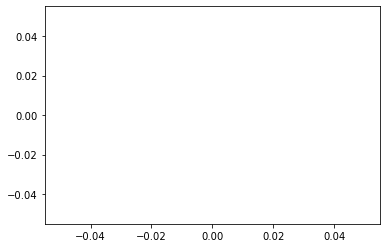

In [43]:
plt.plot(loss)

In [ ]:
ans = np.dot(adj,vector)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(learning_rate=100,perplexity=6)
transformed = model.fit_transform(ans)
xs = transformed[:,0]
ys = transformed[:,1]

for i in range(len(xs)):
    plt.scatter(xs[i],ys[i],c = np.array(34))
    plt.text(xs[i],ys[i],node_number[i])
plt.scatter(xs,ys)
#plt.text(xs,ys)

plt.show()